# Viral proteins in bulk RNA seq data

[Open in Google Colab](https://colab.research.google.com/github/pachterlab/kb_docs/blob/main/docs/source/translated/notebooks/virus_detection_bulk.ipynb)   
Click "Runtime" -> "Run all" to run this notebook.

In this tutorial, we will align RNA sequencing data collected from SARS-CoV2 infected human iPSC derived cardiomyocytes to viral RdRP protein sequences. Let's see if we can detect SARS-CoV2 RdRP-like sequences as expected. This is a SMART-seq dataset, but the workflow is the same for bulk RNA sequencing data.

**Workflow reference**:  
Laura Luebbert, Delaney K Sullivan, Maria Carilli, Kristján Eldjárn Hjörleifsson, Alexander Viloria Winnett, Tara Chari, Lior Pachter (2023). [Efficient and accurate detection of viral sequences at single-cell resolution reveals novel viruses perturbing host gene expression](https://www.biorxiv.org/content/10.1101/2023.12.11.571168). *bioRxiv* 2023.12.11.571168; doi: https://doi.org/10.1101/2023.12.11.571168

**Data references**:  
RNA seq data: https://www.cell.com/cell-reports-medicine/pdf/S2666-3791(20)30068-9.pdf  
PalmDB viral protein (RdRP) reference database:  https://www.nature.com/articles/s41586-021-04332-2  

PalmDB is an uncurated database of viral RNA-dependent RNA polymerase (RdRP) sequences, primarily derived from metagenomic sources. Consequently, some entries may originate from non-viral sources or represent host-derived sequences. We provide example code below demonstrating one method for the masking of host sequences and the subsequent extraction and BLAST analysis of the identified reads.

In [ ]:
# SRR numbers of the sequencing dataset(s) to analyze
srr_numbers = ["SRR11777734", "SRR11777735", "SRR11777736", "SRR11777737", "SRR11777738", "SRR11777739"]

# Genus and species of the host (separate by "_")
host_species = "homo_sapiens"

# Here, we will only align a subset of [n_seq_to_keep] sequences from each of these SRRs
# to decrease the runtime of this example notebook
# Set n_seq_to_keep=False to align the complete dataset
n_seq_to_keep = 10000000

# Number of threads to use during alignments
threads = 2

# k-mer length: Increase k for increased specificity (at a potential trade-off with sensitivity)
# k should be an odd integer and should be >=31 for translated alignment
# Since k relates to nucleotides and not amino acids, k corresponds to matching ⌊k/3⌋ amino acids (for k=31, this corresponds to ⌊31/3⌋=10 amino acids)
k = 31

## Install software

In [ ]:
!pip install -q ffq gget kb_python==0.29.1 anndata==0.10.9

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.5/36.5 MB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.0/129.0 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.1/43.1 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 82.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 45.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 74.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 62.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.0/22.0 M

In [ ]:
import anndata
import gget
import glob
import gzip
import json
import matplotlib.colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import platform
from Bio import SeqIO

%config InlineBackend.figure_format='retina'

In [ ]:
# This step will not be necessary after the next kb release
if k<32:
  # Install kallisto v0.50.0 from source
  # This version performs translated search faster while providing the same results as later versions, but it does not support k>31
  # (the features to increase runtime and support k>31 will be incorporated into the next version of kb, so this step will not be necessary after the next release)
  !git clone https://github.com/pachterlab/kallisto.git --branch v0.50.0
  !cd kallisto && mkdir build && cd build && cmake .. && make
  kallisto = "kallisto/build/src/kallisto"
else:
  # Find the kallisto binary installed automatically with kb (or simply remove the --kallisto arguments below)
  kallisto = glob.glob(f"/usr/local/lib/python*/dist-packages/kb_python/bins/{platform.system().lower()}/kallisto/kallisto_k64")[0]

## Download the RNA sequencing data
Use [ffq](https://github.com/pachterlab/ffq) to download the sequencing data from the SRR numbers:

In [ ]:
# Get ftp download links for raw data with ffq and store results in json file
srr_numbers = " ".join(srr_numbers)
!ffq $srr_numbers \
    --ftp \
    -o ffq.json

# Load ffq output
f = open("ffq.json")
data_json = json.load(f)
f.close()

# Download raw data using FTP links fetched by ffq
for dataset in data_json:
    url = dataset["url"]
    !curl -O $url

[2025-01-11 14:04:53,185]    INFO Parsing run SRR11777734
[2025-01-11 14:04:55,640]    INFO Parsing run SRR11777735
[2025-01-11 14:05:00,165]    INFO Parsing run SRR11777736
[2025-01-11 14:05:02,303]    INFO Parsing run SRR11777737
[2025-01-11 14:05:04,384]    INFO Parsing run SRR11777738
[2025-01-11 14:05:06,424]    INFO Parsing run SRR11777739
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2962M  100 2962M    0     0  29.6M      0  0:01:39  0:01:39 --:--:-- 30.5M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2634M  100 2634M    0     0  13.5M      0  0:03:13  0:03:13 --:--:-- 12.3M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2484M  100 2484M

## Download the viral protein reference sequences
In this case, we are using a version of the [PalmDB database v1](https://github.com/ababaian/palmdb) that was optimized for viral sequence detection with kallisto as described in [this manuscript](https://www.biorxiv.org/content/10.1101/2023.12.11.571168). These files are stored in the [GitHub repository](https://github.com/pachterlab/LSCHWCP_2023/tree/main) accompanying the manuscript.

In [ ]:
# Download the virus ID to taxonomy mapping
!wget https://raw.githubusercontent.com/pachterlab/LSCHWCP_2023/main/PalmDB/ID_to_taxonomy_mapping.csv
# Download the customized transcripts to gene mapping
!wget https://raw.githubusercontent.com/pachterlab/LSCHWCP_2023/main/PalmDB/palmdb_clustered_t2g.txt
# Download the RdRP amino acid sequences
!wget https://raw.githubusercontent.com/pachterlab/LSCHWCP_2023/main/PalmDB/palmdb_rdrp_seqs.fa

--2025-01-11 14:18:55--  https://raw.githubusercontent.com/pachterlab/LSCHWCP_2023/main/PalmDB/ID_to_taxonomy_mapping.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19705497 (19M) [text/plain]
Saving to: ‘ID_to_taxonomy_mapping.csv’

ID_to_taxonomy_mapp 100%[===================>]  18.79M  --.-KB/s    in 0.1s    

2025-01-11 14:18:56 (157 MB/s) - ‘ID_to_taxonomy_mapping.csv’ saved [19705497/19705497]

--2025-01-11 14:18:56--  https://raw.githubusercontent.com/pachterlab/LSCHWCP_2023/main/PalmDB/palmdb_clustered_t2g.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request s

## Build a reference index from the viral protein sequences and mask host (here, human) sequences

In addition to building a reference index from the protein sequences, we also want to mask host (in this case, human) sequences. **For a more conservative host masking workflow that incorporates an additional step for the removal of host sequences, see [this notebook](https://github.com/pachterlab/LSCHWCP_2023/blob/main/Notebooks/align_macaque_PBMC_data/7_virus_host_captured_dlist_cdna_dna/1_align_captured_dlist_cdna_dna.ipynb).**  

The [`--aa` argument](https://kallisto.readthedocs.io/en/latest/translated/pseudoalignment.html) tells `kb` that this is an amino acid reference.

The [`--d-list` argument](https://kallisto.readthedocs.io/en/latest/index/index_generation.html#the-d-list) is the path to the host genome/transcriptome. These sequences will be masked in the index. Here, we are using [`gget ref`](https://pachterlab.github.io/gget/en/ref.html) to fetch the latest human genome and transcriptome from Ensembl.

We are using `--workflow custom` here since we do not have a .gtf file for the PalmDB fasta file.

`--kallisto` provides the path to the kallisto binary v0.50.0 (if `k` ≤ 31), which we installed above. This argument can be omitted to use the kallisto binary included in kb.

Building the index can take some time, depending on the number of threads used and the size of the D-list (here, ~20 min), but it only needs to be done once.

In [ ]:
# Download the host reference genome and transcriptome from Ensembl
!gget ref -w cdna,dna -d $host_species

# Concatenate host genome and transcriptome into one file
host_genome = glob.glob("*.dna*.fa.gz")[0]
host_transcriptome = glob.glob("*.cdna.all.fa.gz")[0]
host_genome_transciptome = f"{host_species}.cdna_dna.fa.gz"
!cat $host_genome $host_transcriptome > $host_genome_transciptome

14:19:06 - INFO - Fetching reference information for homo_sapiens from Ensembl release: 113.
{
    "homo_sapiens": {
        "transcriptome_cdna": {
            "ftp": "http://ftp.ensembl.org/pub/release-113/fasta/homo_sapiens/cdna/Homo_sapiens.GRCh38.cdna.all.fa.gz",
            "ensembl_release": 113,
            "release_date": "2024-08-15",
            "release_time": "14:44",
            "bytes": "76M"
        },
        "genome_dna": {
            "ftp": "http://ftp.ensembl.org/pub/release-113/fasta/homo_sapiens/dna/Homo_sapiens.GRCh38.dna.primary_assembly.fa.gz",
            "ensembl_release": 113,
            "release_date": "2024-08-15",
            "release_time": "20:18",
            "bytes": "841M"
        }
    }
}
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 75.9M  100 75.9M    0     0  19.3M      0  0:00:03  0:00:03 --:--:-- 19.3M
  % Total    % Received %

In [ ]:
%%time
# Generate the viral protein reference index with masked host sequences using kallisto
reference_index = f"palmdb_{host_species}_dlist_cdna_dna.idx"

!kb ref \
    --kallisto $kallisto \
    --verbose \
    -t $threads \
    --aa \
    -k $k \
    --workflow custom \
    --d-list $host_genome_transciptome \
    -i $reference_index \
    palmdb_rdrp_seqs.fa

[2025-01-11 14:19:49,218]   DEBUG [main] Printing verbose output
[2025-01-11 14:19:51,424]   DEBUG [main] kallisto binary located at /content/kallisto/build/src/kallisto
[2025-01-11 14:19:51,424]   DEBUG [main] bustools binary located at /usr/local/lib/python3.10/dist-packages/kb_python/bins/linux/bustools/bustools
[2025-01-11 14:19:51,424]   DEBUG [main] Creating `tmp` directory
[2025-01-11 14:19:51,424]   DEBUG [main] Namespace(list=False, command='ref', tmp=None, keep_tmp=False, verbose=True, i='palmdb_homo_sapiens_dlist_cdna_dna.idx', g=None, f1=None, include_attribute=None, exclude_attribute=None, f2=None, c1=None, c2=None, d=None, k=31, t=2, d_list='homo_sapiens.cdna_dna.fa.gz', d_list_overhang=1, aa=True, workflow='custom', distinguish=False, make_unique=False, overwrite=False, kallisto='kallisto/build/src/kallisto', bustools='/usr/local/lib/python3.10/dist-packages/kb_python/bins/linux/bustools/bustools', opt_off=False, fasta='palmdb_rdrp_seqs.fa', gtf=None, feature=None, no_mi

Alternatively, you can download a precomputed PalmDB reference index for use with `kb` in which the human (or mouse) genome and transcriptome were masked. You can find links to all available precomputed reference indeces [here](https://github.com/pachterlab/LSCHWCP_2023/tree/main/precomputed_refs).  
**Note:** These indeces were computed with `k=31`.

In [ ]:
# # Download precomputed index with masked human genome and transcriptome
# k=31
# !wget https://data.caltech.edu/records/sh33z-hrx98/files/palmdb_human_dlist_cdna_dna.idx?download=1
# !mv palmdb_human_dlist_cdna_dna.idx?download=1 palmdb_human_dlist_cdna_dna.idx

## Align data using kallisto translated search

Create a batch file so we can run all fastq files simultaneously (to learn more about batch files, see Box 7 in the [Protocols paper](https://www.biorxiv.org/content/10.1101/2023.11.21.568164v2.full.pdf)):

In [ ]:
if n_seq_to_keep:
    # To decrease the runtime of this example tutorial,
    # we will only align the top [n_seq_to_keep] sequences in each fastq file
    print(f"Number of reads kept per fastq file: {n_seq_to_keep:,}")

with open("batch.txt", "w") as batch_file:
  for filename in np.sort(glob.glob("*.fastq.gz")):

    if n_seq_to_keep:
        # Shorten fastq files (skip this step during a real analysis)
        n_rows_to_keep = n_seq_to_keep * 4
        filename_short = filename.split(".fastq.gz")[0] + "_short.fastq"
        !zcat $filename | head -$n_rows_to_keep > $filename_short
        # Delete original file to save disk space
        !rm $filename
    else:
      filename_short = filename

    # Write batch file in the following format:
    # sample_name \t fastq_filepath
    sample_name = filename.split("/")[-1].split(".")[0]
    batch_file.write(sample_name + "\t" +  filename_short + "\n")

Number of reads kept per fastq file: 10,000,000


The `--aa` argument tells `kb` that this is an amino acid reference.  
The [`-x` argument](https://kallisto.readthedocs.io/en/latest/sc/technologies.html) tells `kb` where to find the barcodes and UMIs in the data.   
The `--h5ad` flag generates a .h5ad file from the count matrix.  
  
**NOTE for paired read data:** kallisto translated search currently does not yet support the simultaneous alignment of paired reads, so `parity` should always be set to 'single' (`--parity single`) and the R1 and R2 files obtained using paired read sequencing should be aligned separately. The resulting matrices from the R1 and R2 reads should provide similar viral counts.

In [ ]:
%%time
out_folder = "kb_output"

!kb count \
    --kallisto $kallisto \
    --verbose \
    -t $threads \
    --aa \
    -k $k \
    -x bulk \
    --parity single \
    -i $reference_index \
    -g palmdb_clustered_t2g.txt \
    --h5ad \
    -o $out_folder \
    batch.txt

[2025-01-11 14:57:23,533]   DEBUG [main] Printing verbose output
[2025-01-11 14:57:25,749]   DEBUG [main] kallisto binary located at /content/kallisto/build/src/kallisto
[2025-01-11 14:57:25,749]   DEBUG [main] bustools binary located at /usr/local/lib/python3.10/dist-packages/kb_python/bins/linux/bustools/bustools
[2025-01-11 14:57:25,749]   DEBUG [main] Creating `kb_output/tmp` directory
[2025-01-11 14:57:25,749]   DEBUG [main] Namespace(list=False, command='count', tmp=None, keep_tmp=False, verbose=True, i='palmdb_homo_sapiens_dlist_cdna_dna.idx', g='palmdb_clustered_t2g.txt', x='bulk', o='kb_output', num=False, w=None, r=None, t=2, m='2G', strand=None, inleaved=False, genomebam=False, aa=True, gtf=None, chromosomes=None, workflow='standard', em=False, mm=False, tcc=False, filter=None, filter_threshold=None, c1=None, c2=None, overwrite=False, dry_run=False, batch_barcodes=False, loom=False, h5ad=True, loom_names='barcode,target_name', sum='none', cellranger=False, gene_names=False, 

## Load generated count matrix

In [ ]:
# Open count matrix generated by kb (AnnData object in h5ad format)
adata = anndata.read_h5ad(f"{out_folder}/counts_unfiltered/adata.h5ad")
adata

AnnData object with n_obs × n_vars = 6 × 99228

Add SRR and sample labels to adata.obs based on the batch barcode assigned by `kb count`:

In [ ]:
def read_list_from_txt(filepath):
  with open(filepath, "r") as file:
      my_list = [line.strip() for line in file]
  return my_list

batch_barcode_df = pd.DataFrame()
batch_barcode_df["batch_name"] = read_list_from_txt(f"{out_folder}/matrix.cells")
batch_barcode_df["batch_barcode"] = read_list_from_txt(f"{out_folder}/matrix.sample.barcodes")
batch_barcode_df

,batch_name,batch_barcode
0,SRR11777734,AAAAAAAAAAAAAAAA
1,SRR11777735,AAAAAAAAAAAAAAAC
2,SRR11777736,AAAAAAAAAAAAAAAG
3,SRR11777737,AAAAAAAAAAAAAAAT
4,SRR11777738,AAAAAAAAAAAAAACA
5,SRR11777739,AAAAAAAAAAAAAACC


In [ ]:
adata.obs = adata.obs.merge(batch_barcode_df, left_on="barcode", right_on="batch_barcode").set_index("batch_barcode")
# Add metadata for each SRR file
adata.obs["sample"] = ['Infected 1', 'Infected 2', 'Infected 3', 'Control 1', 'Control 2', 'Control 3']
adata.obs

,batch_name,sample
batch_barcode,,
AAAAAAAAAAAAAAAA,SRR11777734,Infected 1
AAAAAAAAAAAAAAAC,SRR11777735,Infected 2
AAAAAAAAAAAAAAAG,SRR11777736,Infected 3
AAAAAAAAAAAAAAAT,SRR11777737,Control 1
AAAAAAAAAAAAAACA,SRR11777738,Control 2
AAAAAAAAAAAAAACC,SRR11777739,Control 3


## Plot counts for SARS-CoV RdRP sequences in each sample
Find the virus IDs for SARS-CoV in the PalmDB viral protein reference:

In [ ]:
# Load the PalmDB virus ID to virus taxonomy mapping
# Note: Only the rep_ID will occur in the reference index
u_tax_csv = "ID_to_taxonomy_mapping.csv"
tax_df = pd.read_csv(u_tax_csv)

# Find the virus IDs for SARS-CoV proteins
tax_df[tax_df["species"].str.contains("Severe acute respiratory syndrome")]

,ID,rep_ID,phylum,class,order,family,genus,species,strandedness
0,u1,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...,+ssRNA
1,u10066,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...,+ssRNA
2,u10121,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...,+ssRNA
3,u10124,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...,+ssRNA
4,u102609,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...,+ssRNA
...,...,...,...,...,...,...,...,...,...
404,u889,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...,+ssRNA
405,u9015,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...,+ssRNA
406,u944,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...,+ssRNA
407,u9771,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...,+ssRNA


In [ ]:
# Target virus IDs to plot (here, SARS-CoV)
target_ids = tax_df[tax_df["species"].str.contains("Severe acute respiratory syndrome-related coronavirus")]["rep_ID"].unique()
target_ids

array(['u1'], dtype=object)

Create bar plot showing raw counts for SARS-CoV:

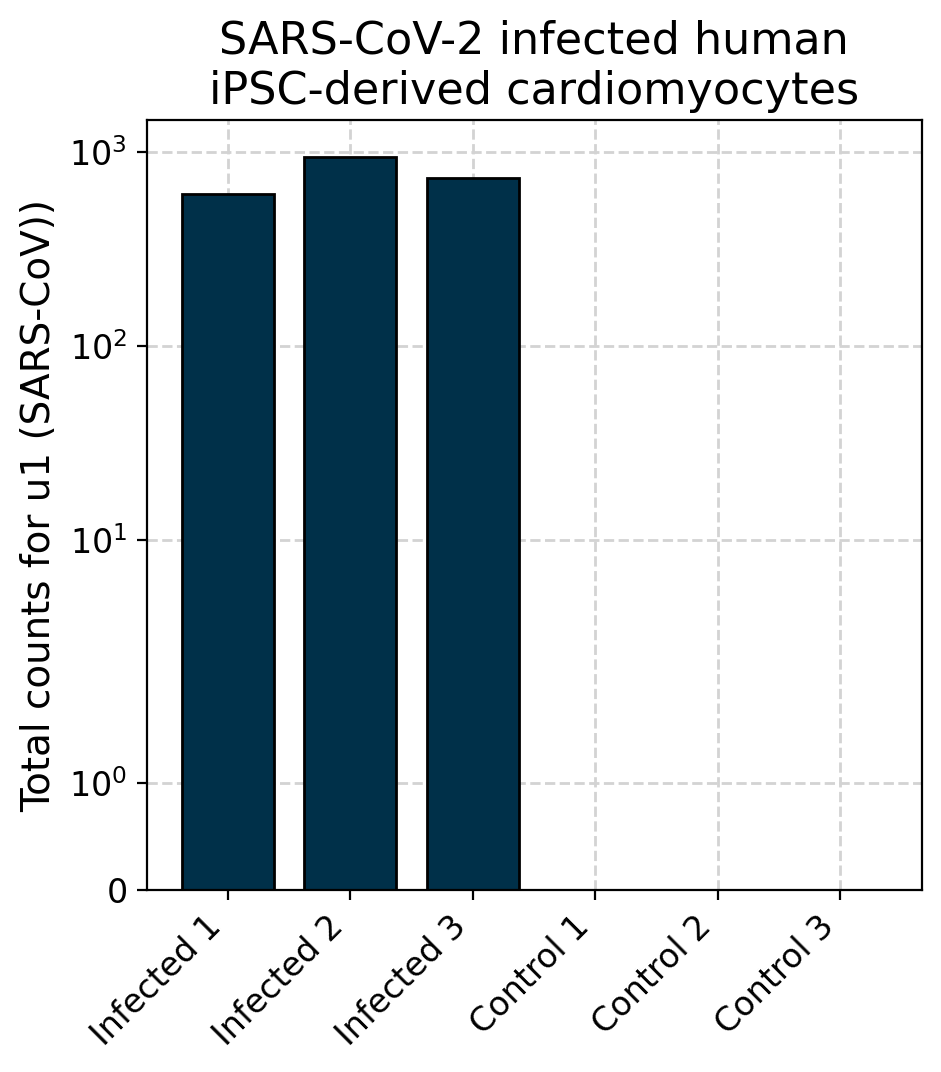

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
fontsize = 14
width = 0.75

samples = adata.obs.index.values
x_labels = adata.obs["sample"].values

# Plot total raw counts
counts = []
labels = samples
for sample in samples:
    counts.append(adata.X[adata.obs.index == sample, adata.var.index.isin(target_ids)].sum())

x = np.arange(len(labels))

ax.bar(x, counts, width=width, color="#003049", edgecolor="black")

# Adjust figure labels and axes
ax.set_yscale("symlog")
ax.set_ylabel(f"Total counts for {target_ids[0]} (SARS-CoV))", fontsize=fontsize)
# ax.set_xlabel("Sample", fontsize=fontsize)
ax.set_xticks(x, x_labels, rotation=45, ha="right")
ax.tick_params(axis="both", labelsize=fontsize-2)
ax.set_title(f"SARS-CoV-2 infected human\niPSC-derived cardiomyocytes", fontsize=fontsize+2)
ax.grid(True, which="both", color="lightgray", ls="--", lw=1)
ax.set_axisbelow(True)

# Save figure
fig.savefig("sars_cov_rdrp_count.png", dpi=300, bbox_inches="tight")

fig.show()

In [ ]:
counts

[611.0, 945.0, 734.0, 0.0, 0.0, 0.0]

## Visualize other virus-like sequences observed in the dataset
When interpreting the presence of other virus- or RdRP-like sequences (each identified by its own virus ID), keep in mind that there will likely be many RdRP-like sequences introduced by contamination of laboratory reagents. A (non-comprehensive) list of virus IDs observed in blank sequencing data is available [here](https://github.com/pachterlab/LSCHWCP_2023/blob/main/viruses_in_blank_reagents/total_raw_count_per_virus_id_in_laboratory_reagents.csv) and we will download it below for comparison to the virus IDs observed in our dataset. Another indication that a sequence may have originated from sample contamination is its uniform presence across all sequenced samples.

In [ ]:
# Download list of virus IDs seen in blank sequencing reagents
!wget https://raw.githubusercontent.com/pachterlab/LSCHWCP_2023/refs/heads/main/viruses_in_blank_reagents/total_raw_count_per_virus_id_in_laboratory_reagents.csv
blank_df = pd.read_csv("total_raw_count_per_virus_id_in_laboratory_reagents.csv")
blank_df

--2025-01-11 16:51:18--  https://raw.githubusercontent.com/pachterlab/LSCHWCP_2023/refs/heads/main/viruses_in_blank_reagents/total_raw_count_per_virus_id_in_laboratory_reagents.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 54642 (53K) [text/plain]
Saving to: ‘total_raw_count_per_virus_id_in_laboratory_reagents.csv’

total_raw_count_per 100%[===================>]  53.36K  --.-KB/s    in 0.009s  

2025-01-11 16:51:18 (5.76 MB/s) - ‘total_raw_count_per_virus_id_in_laboratory_reagents.csv’ saved [54642/54642]



,count,virus
0,5374210.0,u172514
1,4301784.0,u226460
2,752771.0,u237705
3,456424.0,u202260
4,359783.0,u223701
...,...,...
4573,1.0,u169611
4574,1.0,u41840
4575,1.0,u169761
4576,1.0,u169999


Plot the top 20 virus IDs observed in this dataset (raw counts are normalized to the total number of viral reads in each sample, and **virus IDs also observed in blank sequencing reagents are marked in red**):

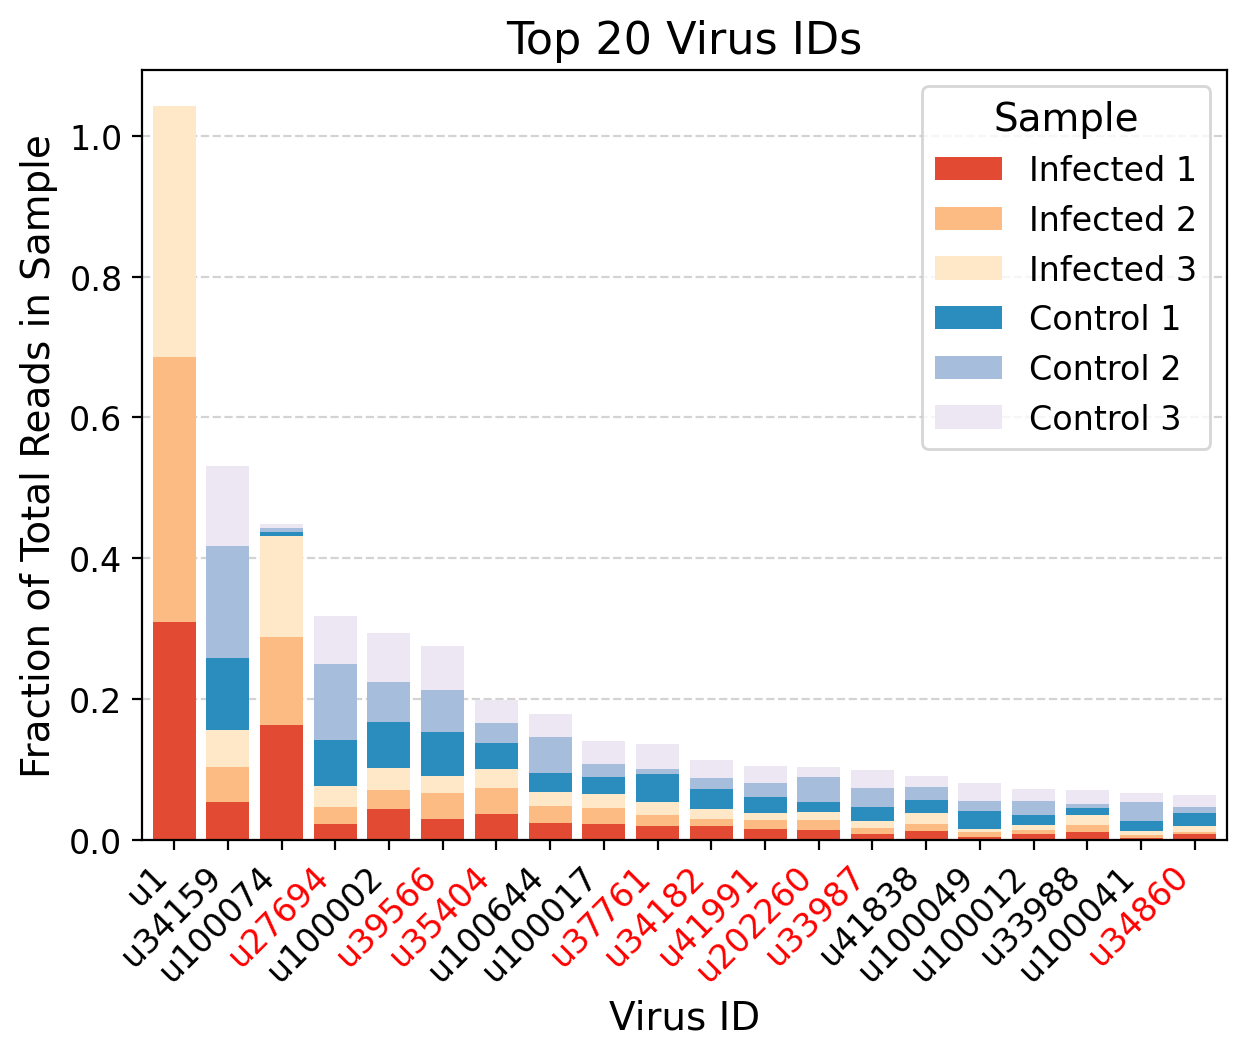

In [ ]:
def plot_top_virs_stacked_bar(adata, top_n=20):
    # Convert sparse matrix to dense if needed
    counts_matrix = adata.X
    if not isinstance(counts_matrix, np.ndarray):
        counts_matrix = counts_matrix.toarray()

    # Calculate total reads per sample
    sample_totals = counts_matrix.sum(axis=1, keepdims=True)

    # Normalize counts by total reads per sample to get fractions
    normalized_counts = counts_matrix / sample_totals

    # Sum normalized counts across all samples for each virus
    vir_totals = normalized_counts.sum(axis=0)

    # Get the top N viruses across all samples
    top_vir_indices = np.argsort(vir_totals)[-top_n:][::-1]
    top_virs = adata.var_names[top_vir_indices]
    top_counts = normalized_counts[:, top_vir_indices]

    sample_ids = adata.obs["sample"].values

    # Create a stacked bar plot
    fig, ax = plt.subplots(figsize=(7, 5))
    colors = ['#e34a33', '#fdbb84', '#fee8c8', '#2b8cbe', '#a6bddb', '#ece7f2']
    fontsize = 14

    bar_bottom = np.zeros(top_n)
    for i, sample_id in enumerate(sample_ids):
        sample_fractions = top_counts[i, :]
        ax.bar(
            top_virs,
            sample_fractions,
            bottom=bar_bottom,
            color=colors[i % len(colors)],
            label=sample_id
        )
        bar_bottom += sample_fractions

    # Adjust figure labels and axes
    ax.set_title(f"Top {top_n} Virus IDs", fontsize=fontsize+2)
    ax.set_xlabel("Virus ID", fontsize=fontsize)
    ax.set_ylabel("Fraction of Total Reads in Sample", fontsize=fontsize)
    ax.set_xticklabels(top_virs, rotation=45, ha='right')
    # Mark virus IDs that have been observed in blank sequencing reagents in red
    for i, label in enumerate(top_virs):
        if label in blank_df["virus"].values:
            ax.get_xticklabels()[i].set_color('red')
    ax.legend(title="Sample", loc='upper right', fontsize=fontsize-2, title_fontsize=fontsize)
    ax.tick_params(axis='both', which='major', labelsize=fontsize-2)
    ax.grid(axis='y', linestyle='--', color="lightgrey", alpha=1)
    ax.set_axisbelow(True)
    ax.margins(x=0.01)
    ax.set_ylim(0, np.max(bar_bottom) * 1.05)

    # Save figure
    fig.savefig("top_virus_IDs_per_sample.png", dpi=300, bbox_inches="tight")

    fig.show()

    return top_virs

top_virs = plot_top_virs_stacked_bar(adata, top_n=20)

Show the predicted taxonomies for each virus ID shown in the plot above (these are the species-like operational taxonomic units (OTUs) provided by PalmDB):

In [ ]:
top_vir_tax = tax_df[tax_df["rep_ID"].isin(top_virs)][tax_df.columns[1:]].drop_duplicates()
top_vir_tax['rep_ID'] = pd.Categorical(top_vir_tax['rep_ID'], categories=top_virs, ordered=True)
top_vir_tax = top_vir_tax.sort_values('rep_ID')
top_vir_tax

,rep_ID,phylum,class,order,family,genus,species,strandedness
0,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...,+ssRNA
35782,u34159,.,.,.,.,.,.,unknown
150602,u100074,Lenarviricota,Howeltoviricetes,Cryppavirales,.,.,.,+ssRNA
34276,u27694,Peploviricota,Herviviricetes,Herpesvirales,Herpesviridae,Varicellovirus,Bubaline alphaherpesvirus 1,dsDNA
66423,u100002,Lenarviricota,Allassoviricetes,Levivirales,.,.,.,+ssRNA
37641,u39566,.,.,.,.,.,.,unknown
36132,u35404,.,.,.,.,.,.,unknown
207936,u100644,Lenarviricota,Amabiliviricetes,Wolframvirales,.,.,.,+ssRNA
106844,u100017,Lenarviricota,Allassoviricetes,Levivirales,Leviviridae,.,.,+ssRNA
37033,u37761,.,.,.,.,.,.,unknown


To confirm the presence of a known virus for which a reference genome is available, you can align the data to the viral (nucleotide) reference genome using the standard `kb` workflow (simply omit the `--aa` flag in the `kb ref` and `kb count` commands and supply the viral reference genome to `kb ref` instead of the PalmDB protein reference).  

## Extract reads that aligned to specific virus IDs for further analysis
If this approach fails or no reference genome is available, use `kb extract` to extract raw reads that aligned to a given virus ID for further analysis (such as BLAST alignment):

In [ ]:
# Sequences that matched to [vir_ids_to_extract] will be extracted
# Here, we will extract reads that mapped to the virus ID u100074
# u100074 is interesting because it was only observed in infected samples
vir_ids_to_extract = ["u100074"]

# Provide a single fastq file to extract reads from (here, we are using "Infected 1")
fastq_file = "/content/SRR11777734_short.fastq"

In [ ]:
%%time
# Extract reads using kb extract
# kb extract will output a new fastq file containing the extracted reads for each target virus ID
outfolder_extract = "extracted_seqs"
targets = " ".join(vir_ids_to_extract)

!kb extract \
    --kallisto $kallisto \
    --verbose \
    -t $threads \
    --aa \
    -g palmdb_clustered_t2g.txt \
    -i $reference_index \
    -ts $targets \
    -o $outfolder_extract \
    $fastq_file

[2025-01-11 16:51:42,733]   DEBUG [main] Printing verbose output
[2025-01-11 16:51:44,941]   DEBUG [main] kallisto binary located at /content/kallisto/build/src/kallisto
[2025-01-11 16:51:44,941]   DEBUG [main] bustools binary located at /usr/local/lib/python3.10/dist-packages/kb_python/bins/linux/bustools/bustools
[2025-01-11 16:51:44,941]   DEBUG [main] Creating `extracted_seqs/tmp` directory
[2025-01-11 16:51:44,941]   DEBUG [main] Namespace(list=False, command='extract', tmp=None, keep_tmp=False, verbose=True, fastq='/content/SRR11777734_short.fastq', i='palmdb_homo_sapiens_dlist_cdna_dna.idx', targets=['u100074'], target_type='gene', extract_all=False, extract_all_fast=False, extract_all_unmapped=False, mm=False, g='palmdb_clustered_t2g.txt', o='extracted_seqs', t=2, strand=None, aa=True, N=None, kallisto='kallisto/build/src/kallisto', bustools='/usr/local/lib/python3.10/dist-packages/kb_python/bins/linux/bustools/bustools', opt_off=False, k=31)
[2025-01-11 16:51:47,837]    INFO [

In [ ]:
# Grab the reads extracted by kb extract for each virus ID
def get_all_sequences(fastq_file):
    """Extract all sequences from a gzipped FASTQ file."""
    sequences = []
    with gzip.open(fastq_file, "rt") as f:
        for record in SeqIO.parse(f, "fastq"):
            sequences.append(str(record.seq))
    return sequences

extracted_seqs_dict = {}
for vir_id in vir_ids_to_extract:
    # Grab the reads from the fastq file returned by kb extract
    seqs = get_all_sequences(f"{outfolder_extract}/{vir_id}/1.fastq.gz")
    # Save the extracted reads for each virus ID in a dictionary
    extracted_seqs_dict[vir_id] = seqs

## BLAST extracted reads
BLAST the first read extracted for the first virus ID (here, u100074) using [`gget blast`](https://pachterlab.github.io/gget/en/blast.html) to see which known reference sequences it aligns to:

In [ ]:
seq_idx = 0
raw_read = extracted_seqs_dict[vir_ids_to_extract[0]][seq_idx]

blast_df = gget.blast(raw_read)
blast_df

INFO:gget.utils:Sequence recognized as nucleotide sequence.
INFO:gget.utils:BLAST will use program 'blastn' with database 'nt'.
INFO:gget.utils:BLAST initiated with search ID S59M77GX016. Estimated time to completion: 30 seconds.
INFO:gget.utils:Retrieving results...
/usr/local/lib/python3.10/dist-packages/gget/gget_blast.py:327: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  results_df = pd.read_html(str(dsc_table))[0]


,Description,Scientific Name,Common Name,Taxid,Max Score,Total Score,Query Cover,E value,Per. Ident,Acc. Len,Accession
0,Severe acute respiratory syndrome coronavirus ...,Severe acute respiratory syndrome coronavirus 2,NaN,2697049,124,124,100%,9.000000e-25,96.05%,29890,OV107737.2
1,Severe acute respiratory syndrome coronavirus ...,Severe acute respiratory syndrome coronavirus 2,NaN,2697049,124,124,100%,9.000000e-25,96.05%,29655,OQ122586.1
2,Severe acute respiratory syndrome coronavirus ...,Severe acute respiratory syndrome coronavirus 2,NaN,2697049,124,124,100%,9.000000e-25,96.05%,29715,OQ579903.1
3,Severe acute respiratory syndrome coronavirus ...,Severe acute respiratory syndrome coronavirus 2,NaN,2697049,124,124,100%,9.000000e-25,96.05%,29718,OP415689.1
4,Severe acute respiratory syndrome coronavirus ...,Severe acute respiratory syndrome coronavirus 2,NaN,2697049,124,124,100%,9.000000e-25,96.05%,29841,OX424285.1
5,Severe acute respiratory syndrome coronavirus ...,Severe acute respiratory syndrome coronavirus 2,NaN,2697049,124,124,100%,9.000000e-25,96.05%,29850,OX858193.1
6,Severe acute respiratory syndrome coronavirus ...,Severe acute respiratory syndrome coronavirus 2,NaN,2697049,124,124,100%,9.000000e-25,96.05%,29890,OV024669.1
7,Severe acute respiratory syndrome coronavirus ...,Severe acute respiratory syndrome coronavirus 2,NaN,2697049,124,124,100%,9.000000e-25,96.05%,29747,OQ697877.1
8,Severe acute respiratory syndrome coronavirus ...,Severe acute respiratory syndrome coronavirus 2,NaN,2697049,124,124,100%,9.000000e-25,96.05%,29868,OZ080834.1
9,Severe acute respiratory syndrome coronavirus ...,Severe acute respiratory syndrome coronavirus 2,NaN,2697049,124,124,100%,9.000000e-25,96.05%,29817,OW805761.1


It looks like reads mapped to virus ID u100074 might have also belonged to SARS-CoV2 (these reads mapped to u100074 instead of u1—for which the predicted taxonomy is SARS-CoV), potentially suggesting the presence of multiple SARS-CoV2 variants or viral evolution in the cardiomyocytes.

For inspiration regarding further analysis, each figure from [our manuscript](https://doi.org/10.1101/2023.12.11.571168) can be reproduced using [these notebooks](https://github.com/pachterlab/LSCHWCP_2023/tree/main/Notebooks).